In [1]:
# dataset from: https://www.kaggle.com/c/bike-sharing-demand

### Bike Sharing Demand Prediction

The study of variables that affect the use of bike-sharing services and the demand for bikes at various times and locations is referred to as bike-sharing demand analysis. Understanding usage patterns and trends for bikes is the goal of this investigation, which also aims to forecast future demand. The ability of statistical machine-learning approaches to analyse the provided data will be examined in this notebook.

Learning Objectives:

- Based on historical data and other pertinent parameters, anticipate with accuracy the number of bike rentals for a specific time period and location.
- Determine and examine the important variables that affect the demand for bike rentals, such as weather, holidays, and events.
- Utilising regression analysis to create and assess prediction models that can accurately forecast the demand for bike rentals.
- Utilising the outcomes of the forecasts will help bike-sharing companies satisfy consumer demand and increase income by optimising bike inventory and resources.
- Maintain a constant eye on forecasting precision, analyse it, enhance model

#### What is forecasting demand for bike sharing?
The goal of bike-sharing demand forecasting is to give bike-sharing businesses the knowledge and resources they need to manage their business operations and make data-driven choices.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
df = pd.read_csv('bike_share.csv')
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


Data Description:
- datetime - hourly date + timestamp  
- season -  1 = spring, 2 = summer, 3 = fall, 4 = winter
- holiday - whether the day is considered a holiday
- workingday - whether the day is neither a weekend nor holiday
- weather -
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- temp - temperature in Celsius
- atemp - "feels like" temperature in Celsius
- humidity - relative humidity
- windspeed - wind speed
- casual - number of non-registered user rentals initiated
- registered - number of registered user rentals initiated
- count - number of total rentals

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [5]:
df.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


In [6]:
#Season-wise total rentals
season_rental = df.groupby('season')['count'].sum()
season_rental

season
1    312498
2    588282
3    640662
4    544034
Name: count, dtype: int64

<AxesSubplot:xlabel='season'>

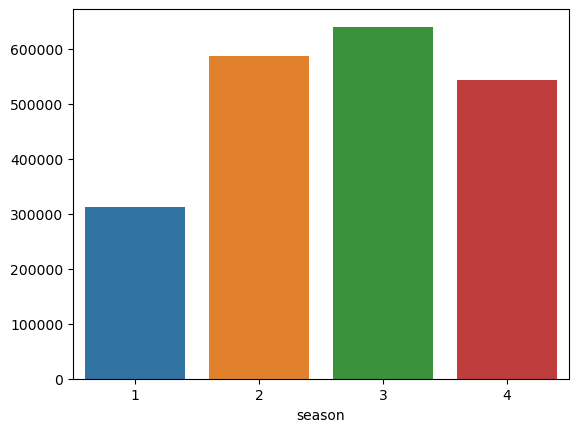

In [7]:
sns.barplot(x=season_rental.index, y=season_rental.values)

The total rentals were the highest during fall

In [8]:
df['datetime'] = pd.to_datetime(df['datetime'])

In [9]:
df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.weekday

In [10]:
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,month,day
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,1,5
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1,5
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,1,5
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,1,5
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,1,5


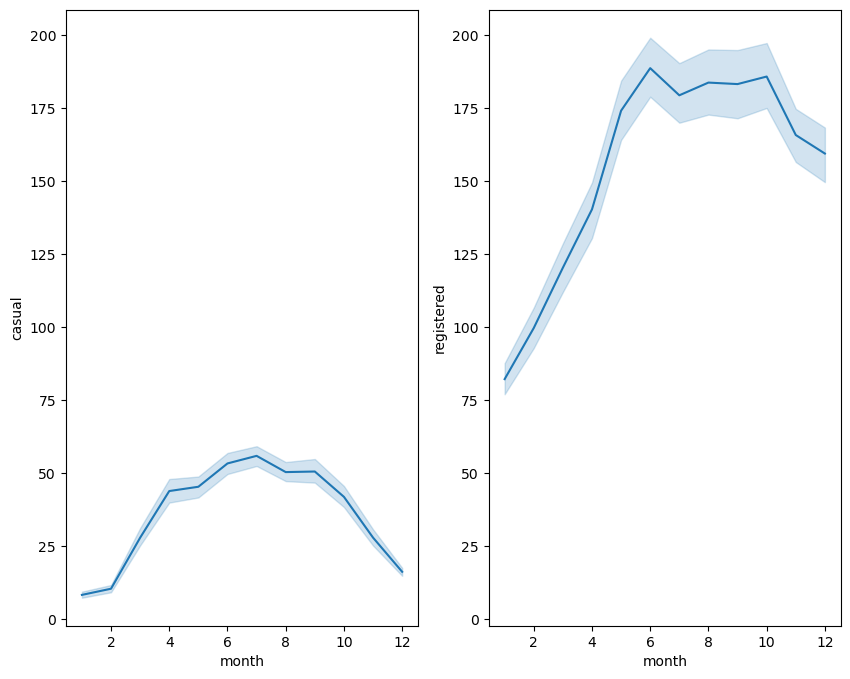

In [11]:
#Registered vs unregistered user rentals based on month
plt.figure(figsize=(10,8))
ax1 = plt.subplot(1,2,1)
sns.lineplot(data=df, x='month', y='casual', markers='o')
ax1 = plt.subplot(1,2,2,sharey=ax1)
sns.lineplot(data=df, x='month', y='registered', markers='o')
plt.show()

- Unregistered rentals peak during the months of June through July, post the uptrend in the beginning of the year.
- There are more of registered rentals compared to the casual ones; the former also showcases an upward trend through Jan to June and thereafter, slows down a bit.

<AxesSubplot:xlabel='temp', ylabel='count'>

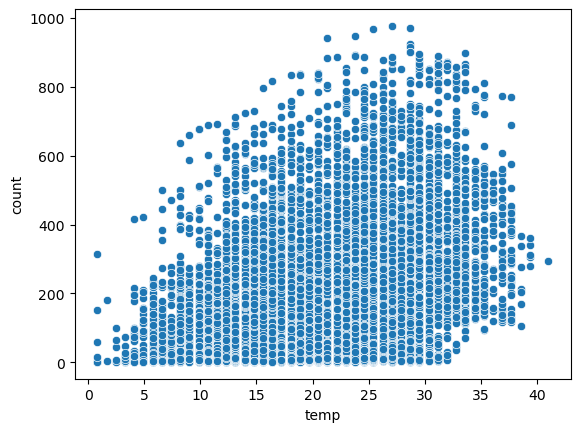

In [12]:
#Temperature and bike rentals correlation
sns.scatterplot(data=df, x='temp', y='count')

<AxesSubplot:xlabel='temp', ylabel='count'>

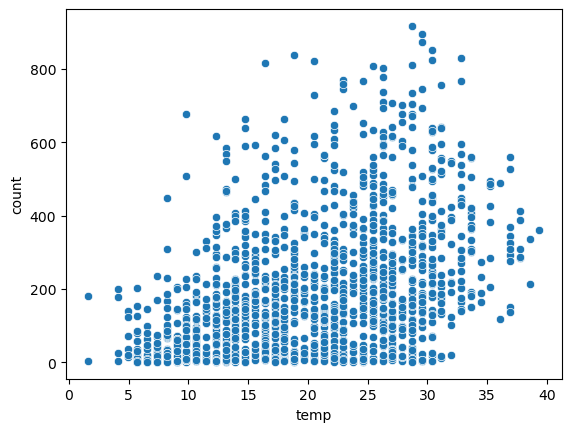

In [13]:
sample = df.sample(1500)
sns.scatterplot(data=sample, x='temp', y='count')

In [14]:
temp_rent_corr = df[['temp','count']].corr()
temp_rent_corr

,temp,count
temp,1.000000,0.394454
count,0.394454,1.000000


The rentals tend to decrease when the temperature is extreme which is intuitive in itself.

In [15]:
#Categorical encoding
season_type = pd.get_dummies(df['season'], prefix = 'season_', drop_first = True)
weather_type = pd.get_dummies(df['weather'], prefix = 'weather_', drop_first = True)

In [16]:
df = pd.concat([df, season_type, weather_type], axis = 1)
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,month,day,season__2,season__3,season__4,weather__2,weather__3,weather__4
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,1,5,0,0,0,0,0,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1,5,0,0,0,0,0,0
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,1,5,0,0,0,0,0,0
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,1,5,0,0,0,0,0,0
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,1,5,0,0,0,0,0,0


In [17]:
# df["Quarter_JanFebMar"] = df["month"].apply(lambda x: 1 if x<=3 else 0)
# df["Quarter_AprMayJun"] = df["month"].apply(lambda x: 1 if 4<=x<=6 else 0)
# df["Quarter_JulAugSep"] = df["month"].apply(lambda x: 1 if 7<=x<=9 else 0)

In [18]:
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,month,day,season__2,season__3,season__4,weather__2,weather__3,weather__4
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,1,5,0,0,0,0,0,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1,5,0,0,0,0,0,0
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,1,5,0,0,0,0,0,0
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,1,5,0,0,0,0,0,0
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,1,5,0,0,0,0,0,0


In [19]:
# df["weekend"] = df["day"].apply(lambda x: 0 if 0<=x<=4 else 1) # Monday-0 to Sunday-6

In [20]:
df = df.drop(columns=['datetime', 'season', 'weather', 'month', 'day', "casual", "registered", "workingday", "temp"],axis=1)

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   holiday     10886 non-null  int64  
 1   atemp       10886 non-null  float64
 2   humidity    10886 non-null  int64  
 3   windspeed   10886 non-null  float64
 4   count       10886 non-null  int64  
 5   season__2   10886 non-null  uint8  
 6   season__3   10886 non-null  uint8  
 7   season__4   10886 non-null  uint8  
 8   weather__2  10886 non-null  uint8  
 9   weather__3  10886 non-null  uint8  
 10  weather__4  10886 non-null  uint8  
dtypes: float64(2), int64(3), uint8(6)
memory usage: 489.1 KB


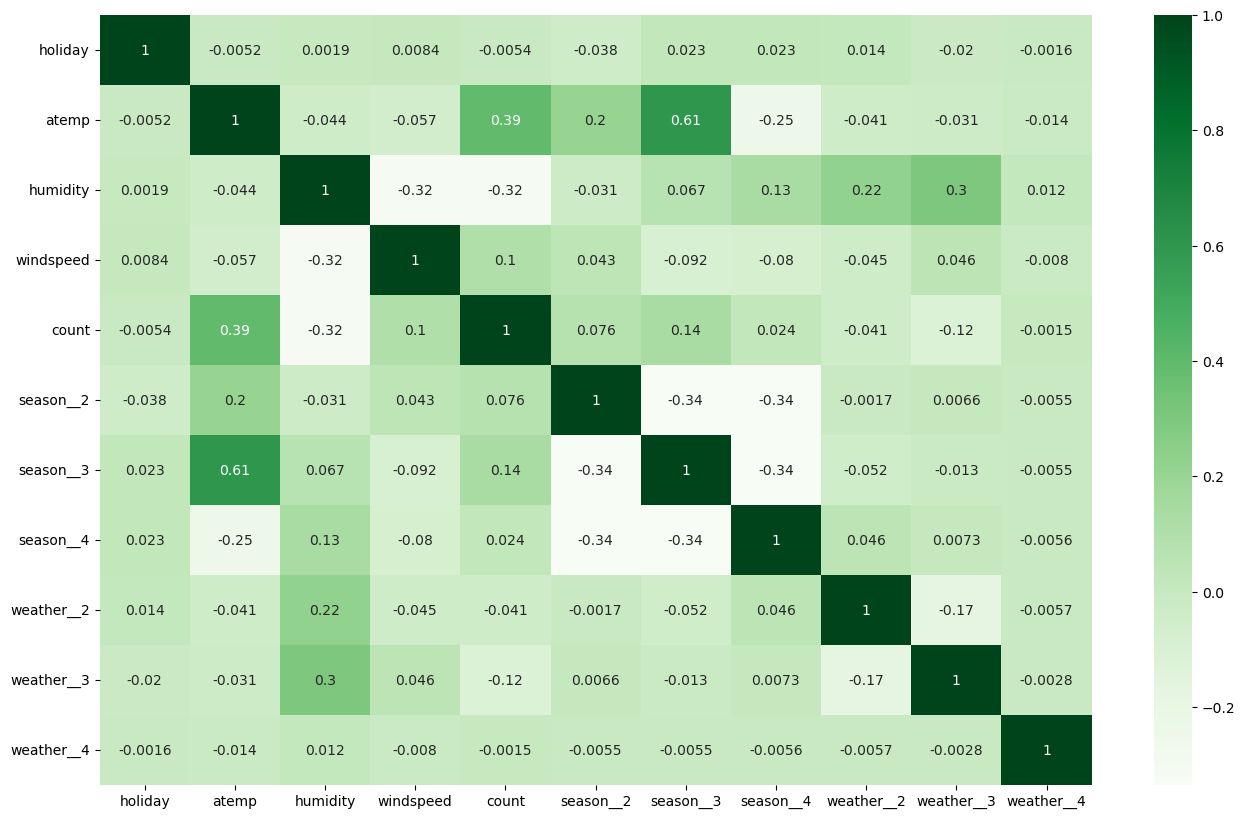

In [22]:
plt.figure(figsize = (16, 10))
sns.heatmap(df.corr(), annot = True, cmap="Greens")
plt.show()

In [23]:
#Dropping column temp since it is very highly collinear with the column atemp.
#Further,the column atemp is more appropriate for modelling compared to column temp from human perspective.

# df.drop(columns=["temp"],axis=1,inplace =True)

In [24]:
scaler = MinMaxScaler()
numeric_var = ['atemp','humidity','windspeed']
df[numeric_var] = scaler.fit_transform(df[numeric_var])

# Analysing the train dataframe after scaling
df.head()

,holiday,atemp,humidity,windspeed,count,season__2,season__3,season__4,weather__2,weather__3,weather__4
0,0,0.305068,0.81,0.0,16,0,0,0,0,0,0
1,0,0.288064,0.80,0.0,40,0,0,0,0,0,0
2,0,0.288064,0.80,0.0,32,0,0,0,0,0,0
3,0,0.305068,0.75,0.0,13,0,0,0,0,0,0
4,0,0.305068,0.75,0.0,1,0,0,0,0,0,0


In [25]:
x = df.drop('count', axis=1)
y = df['count']

In [41]:
import statsmodels.api as sm

xtrain, xtest, ytrain, ytest = train_test_split(x, y, train_size = 0.7, test_size = 0.3, random_state = 123)
xtrain = sm.add_constant(xtrain)
xtest = sm.add_constant(xtest)

Feature ranking with recursive feature elimination.

Given an external estimator that assigns weights to features (e.g., the coefficients of a linear model), the goal of recursive feature elimination (RFE) is to select features by recursively considering smaller and smaller sets of features. First, the estimator is trained on the initial set of features and the importance of each feature is obtained either through any specific attribute or callable. Then, the least important features are pruned from current set of features. That procedure is recursively repeated on the pruned set until the desired number of features to select is eventually reached.

In [42]:
# Running RFE with the output number of the variable equal to 12
model1 = sm.OLS(ytrain, xtrain)
results1 = model1.fit()
print(results1.summary())

                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.281
Model:                            OLS   Adj. R-squared:                  0.280
Method:                 Least Squares   F-statistic:                     330.5
Date:                Fri, 07 Jul 2023   Prob (F-statistic):               0.00
Time:                        14:45:02   Log-Likelihood:                -49190.
No. Observations:                7620   AIC:                         9.840e+04
Df Residuals:                    7610   BIC:                         9.847e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        117.1890     10.385     11.285      0.0

c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1918: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])


c:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


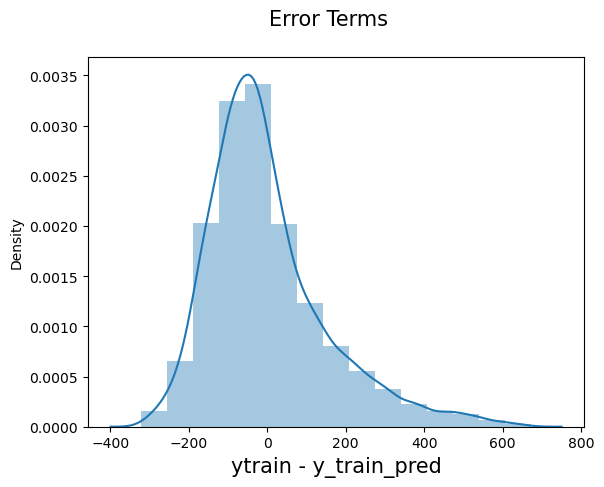

In [44]:
y_train_pred = results1.predict(xtrain)
res = (ytrain - y_train_pred)

fig = plt.figure()
sns.distplot(res, bins = 15)
fig.suptitle('Error Terms', fontsize = 15)                  # Plot heading
plt.xlabel('ytrain - y_train_pred', fontsize = 15)          # X-label
plt.show()

In [45]:
predictions = results1.predict(xtest)

In [46]:
mean_squared_error(ytest, predictions)

24189.41955547703

In [47]:
r2_score(ytest, predictions)

0.25541285875880115

### end of notebook